## Part 1

### Challenge:
As AirBnB's webpage announces a raise on this elements, we should check on number of reservations and increase of night price.

#### Samples:
The best option would be to perform an A/B test on flats of similar characteristics, but that correspond to the mean of the market.

#### Metrics:
- Conversion rates (number of reservations).
- Click rates.
- Night price.

#### Hypothesis:
- The professional photo increments the views of the rental flat.
- Therefore, the user rents it more often.
- And can rise its price, as there's more demand

#### Period:
It should last at least 1 week, and 1 month would be ideal to see if weekends affect the metrics.

## Part 2

The designed experiment is very simple. For a period of 5 days, all trips in 3 cities (Bravos, Pentos and Volantis) have been randomly assigned using linear or road distance:

- Trips whose trip_id starts with digits 0-8 were assigned using road distance.
- Trips whose trip_id starts with digits 9-f were assigned using linear distance.

Data description
The collected data is available in this link. Each object represent a vehicle_interval that contains the following attributes:

- duration: how long the interval last, in seconds.
- distance: how far the vehicle moved in this interval, in meters.
- started_at: when the interval started, UTC Time.
- trip_id: uniquely identifies the trip.
- vehicle_id: uniquely identifies the vehicle.
- rider_id: uniquely identifies the rider. (Not found in the data)
- city_id: either bravos, pentos and volantis.
- type: can be going_to_pickup, waiting_for_rider or driving_to_destination.


## Challenge
Try to answer the following questions:

- Should the company move towards road distance? What's the max price it would make sense to pay per query? (make all the assumptions you need, and make them explicit)
- How would you improve the experimental design? Would you collect any additional data?

In [1]:
import numpy as np, pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
import datetime

In [2]:
data = pd.read_json('data/intervals_challenge.json', lines=True)
original_data = pd.read_json('data/intervals_challenge.json', lines=True)
data.head()

,duration,distance,started_at,trip_id,vehicle_id,city_id,type
0,857,5384,2016-10-03 13:00:00.286999941,c00cee6963e0dc66e50e271239426914,52d38cf1a3240d5cbdcf730f2d9a47d6,pentos,driving_to_destination
1,245,1248,2016-10-03 13:00:00.852999926,427425e1f4318ca2461168bdd6e4fcbd,8336b28f24c3e7a1e3d582073b164895,volantis,going_to_pickup
2,1249,5847,2016-10-03 13:00:01.670000076,757867f6d7c00ef92a65bfaa3895943f,8885c59374cc539163e83f01ed59fd16,pentos,driving_to_destination
3,471,2585,2016-10-03 13:00:01.841000080,d09d1301d361f7359d0d936557d10f89,81b63920454f70b6755a494e3b28b3a7,bravos,going_to_pickup
4,182,743,2016-10-03 13:00:01.970000029,00f20a701f0ec2519353ef3ffaf75068,b73030977cbad61c9db55418909864fa,pentos,going_to_pickup


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165170 entries, 0 to 165169
Data columns (total 7 columns):
duration      165170 non-null object
distance      165170 non-null object
started_at    165170 non-null datetime64[ns]
trip_id       165170 non-null object
vehicle_id    165170 non-null object
city_id       165170 non-null object
type          165170 non-null object
dtypes: datetime64[ns](1), object(6)
memory usage: 8.8+ MB


In [4]:
data.shape

(165170, 7)

#### Because we only need the trips to pickup we can already sort it out:

In [5]:
data.type.value_counts()

going_to_pickup           58510
waiting_for_rider         53746
driving_to_destination    52914
Name: type, dtype: int64

In [6]:
data_pickup = data[data.type == 'going_to_pickup'].copy()

In [7]:
data_pickup.head()

,duration,distance,started_at,trip_id,vehicle_id,city_id,type
1,245,1248,2016-10-03 13:00:00.852999926,427425e1f4318ca2461168bdd6e4fcbd,8336b28f24c3e7a1e3d582073b164895,volantis,going_to_pickup
3,471,2585,2016-10-03 13:00:01.841000080,d09d1301d361f7359d0d936557d10f89,81b63920454f70b6755a494e3b28b3a7,bravos,going_to_pickup
4,182,743,2016-10-03 13:00:01.970000029,00f20a701f0ec2519353ef3ffaf75068,b73030977cbad61c9db55418909864fa,pentos,going_to_pickup
5,599,1351,2016-10-03 13:00:02.154000044,158e7bc8d42e1d8c94767b00c8f89568,126e868fb282852c2fa95d88878686bf,volantis,going_to_pickup
9,1525,2674,2016-10-03 13:00:05.637000084,d3e6e8fb50c02d66feca2c60830c4fcc,b0906e917dc5cc0bcba190fd80079a74,bravos,going_to_pickup


We want to compare linear from road trips, so we should make the visualization easier than the rule we have of 'trip_id starts with 0-8 or 9-f'.

#### Define a function to sort linear from road trips

In [8]:
def find_type(value):
    test = [str(i) for i in range(0,9)]
    if value.startswith(tuple(test)):
        return "road"
    else:
        return "linear"
    
data_pickup["trip_type"] = data_pickup["trip_id"].apply(find_type)

In [9]:
data_pickup.head(2)

,duration,distance,started_at,trip_id,vehicle_id,city_id,type,trip_type
1,245,1248,2016-10-03 13:00:00.852999926,427425e1f4318ca2461168bdd6e4fcbd,8336b28f24c3e7a1e3d582073b164895,volantis,going_to_pickup,road
3,471,2585,2016-10-03 13:00:01.841000080,d09d1301d361f7359d0d936557d10f89,81b63920454f70b6755a494e3b28b3a7,bravos,going_to_pickup,linear


In [10]:
data_pickup.trip_type.value_counts()

road      33171
linear    25339
Name: trip_type, dtype: int64

We can observe the road trips are more common than linear trips.

As we are working with only one type of trip and we have sorted both road/linear, we can drop trip_id and type columns.
We will check if we can drop other columns in the future.

In [11]:
data_pickup.drop(columns= ['trip_id', 'type'], inplace = True)

In [12]:
data_pickup.head(2)

,duration,distance,started_at,vehicle_id,city_id,trip_type
1,245,1248,2016-10-03 13:00:00.852999926,8336b28f24c3e7a1e3d582073b164895,volantis,road
3,471,2585,2016-10-03 13:00:01.841000080,81b63920454f70b6755a494e3b28b3a7,bravos,linear


We need to clean duration and distance columns of null.
We will also drop registers equal to 0, as they don't apport reliable data to the analysis.

In [13]:
data_pickup.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58510 entries, 1 to 165169
Data columns (total 6 columns):
duration      58510 non-null object
distance      58510 non-null object
started_at    58510 non-null datetime64[ns]
vehicle_id    58510 non-null object
city_id       58510 non-null object
trip_type     58510 non-null object
dtypes: datetime64[ns](1), object(5)
memory usage: 3.1+ MB


In [14]:
# Because duration and distance are mixed int and str arrays, we need to find out which values are not numbers before cleaning.
data_pickup.duration = data_pickup.duration.astype('str')
data_pickup.sort_values(by = 'duration')

,duration,distance,started_at,vehicle_id,city_id,trip_type
157043,0,0,2016-10-04 19:35:10.690000057,fe144f071ddf727c159cb81424473bc5,pentos,linear
156585,0,32,2016-10-04 19:31:56.186000109,37eeff2c2d3196680f9eeee4551884f3,volantis,linear
16378,0,543,2016-10-03 15:42:15.974999905,985f05a4c0e147abf311780b03dd3bf3,pentos,road
2801,0,34,2016-10-03 13:26:27.805999994,d77bd910c0ca199e66086fbb5d2a330c,pentos,road
45238,0,140,2016-10-03 20:03:38.665999889,af849f228883504a1d6b1b289f32fa8c,pentos,road
...,...,...,...,...,...,...
164555,NA,NA,2016-10-04 20:29:17.187999964,83211681343d5497dffecc7c380de1e3,pentos,linear
164553,NA,NA,2016-10-04 20:29:15.637000084,29d9800ccc54b1b80e4d86f4fcc9d508,pentos,linear
164552,NA,NA,2016-10-04 20:29:14.178999901,fc7018b877aff3a2c5a50fc37c95480b,pentos,road
164599,NA,NA,2016-10-04 20:29:36.647000074,d07b7c02cf576ccab551824f03f492f7,pentos,linear


In [15]:
print('duration NA: ', data_pickup[data_pickup.duration == 'NA'].duration.count())
print('duration 0: ', data_pickup[data_pickup.duration == 0].duration.count())
print('distance NA: ', data_pickup[data_pickup.distance == 'NA'].distance.count())
print('distance 0: ', data_pickup[data_pickup.distance == 0].distance.count())


duration NA:  299
duration 0:  0
distance NA:  299
distance 0:  1421


In [17]:
data_pickup.drop(data_pickup[(data_pickup.duration == 'NA') |
                             (data_pickup.duration == '0') |
                             (data_pickup.distance == 'NA') |
                             (data_pickup.distance == '0')].index,
                 axis=0, inplace=True)

data_pickup.duration = data_pickup.duration.astype('int64')
data_pickup.distance = data_pickup.distance.astype('int64')

In [18]:
data_pickup.reset_index(drop = True)

,duration,distance,started_at,vehicle_id,city_id,trip_type
0,245,1248,2016-10-03 13:00:00.852999926,8336b28f24c3e7a1e3d582073b164895,volantis,road
1,471,2585,2016-10-03 13:00:01.841000080,81b63920454f70b6755a494e3b28b3a7,bravos,linear
2,182,743,2016-10-03 13:00:01.970000029,b73030977cbad61c9db55418909864fa,pentos,road
3,599,1351,2016-10-03 13:00:02.154000044,126e868fb282852c2fa95d88878686bf,volantis,road
4,1525,2674,2016-10-03 13:00:05.637000084,b0906e917dc5cc0bcba190fd80079a74,bravos,linear
...,...,...,...,...,...,...
58184,182,222,2016-10-04 20:33:03.806999922,7a7b7c6ae0671ea05ac039fe4d36874a,volantis,road
58185,22,0,2016-10-04 20:33:14.130000114,7d4c53b2a53cf9ffdee4d9f9f027be3a,volantis,road
58186,77,285,2016-10-04 20:33:28.573999882,57aa029c4c246d713ed03a75cc72700a,volantis,road
58187,17,88,2016-10-04 20:33:49.171999931,05f5cb64e8bfc417e56437e6324d367a,bravos,road


In [19]:
# We can create a column that will combine both numerical columns into one:

data_pickup['speed(m/s)'] = round(data_pickup.distance / data_pickup.duration, 2)
data_pickup.head(2)

,duration,distance,started_at,vehicle_id,city_id,trip_type,speed(m/s)
1,245,1248,2016-10-03 13:00:00.852999926,8336b28f24c3e7a1e3d582073b164895,volantis,road,5.09
3,471,2585,2016-10-03 13:00:01.841000080,81b63920454f70b6755a494e3b28b3a7,bravos,linear,5.49


In [20]:
data_pickup.describe()

,duration,distance,speed(m/s)
count,58189.000000,5.818900e+04,58189.000000
mean,300.279967,9.847189e+02,26.700932
std,291.011881,1.046298e+04,3809.443808
min,1.000000,0.000000e+00,0.000000
25%,141.000000,3.100000e+02,1.680000
50%,237.000000,6.320000e+02,2.570000
75%,371.000000,1.070000e+03,3.620000
max,9441.000000,1.218089e+06,890705.000000


In [21]:
# The max speed is 890705 m/s, which looks unlikely. Let's check the top 10 speeds.

data_pickup.nlargest(10, 'speed(m/s)')

,duration,distance,started_at,vehicle_id,city_id,trip_type,speed(m/s)
42689,1,890705,2016-10-03 19:42:36.312999964,76b5358c1c6e0a088275eb9ee3515506,bravos,linear,890705.00
33646,6,1137902,2016-10-03 18:22:06.230999947,20cb244cf1f99ff6f8966bd163597fc2,bravos,road,189650.33
33526,10,1137915,2016-10-03 18:21:12.326999903,20cb244cf1f99ff6f8966bd163597fc2,bravos,road,113791.50
125609,11,481489,2016-10-04 15:29:23.582999945,49230991f961991ec4ff409a095901e0,bravos,linear,43771.73
104005,51,502384,2016-10-04 12:25:02.571000099,49230991f961991ec4ff409a095901e0,bravos,linear,9850.67
37214,199,1218089,2016-10-03 18:56:19.263999939,c43669ba1841e08d62cad05ea6072265,bravos,road,6121.05
66518,102,374951,2016-10-03 22:57:36.976999998,2bec5bba5cfc7900ea100db9665f4bc3,pentos,road,3675.99
148994,1,3349,2016-10-04 18:33:07.588000059,3a32846d4db07ec1709a95c574ab5373,pentos,linear,3349.00
107927,1,3294,2016-10-04 12:59:45.303999901,2c5a51c9719714988762059cb42e9281,pentos,road,3294.00
39965,5,13786,2016-10-03 19:19:54.680000067,40f783608af850a2b4138d64ed47eec7,pentos,road,2757.20


In [22]:
# Knowing that 120km/h (max allowed on roads in Spain) is 33.33 m/s, we can assume any speed above 35 m/s is a bad lecture.

len(data_pickup[data_pickup['speed(m/s)'] > 35])

565

In [23]:
# As there are only 565 bad lectures we can drop them too.

data_pickup.drop(data_pickup[(data_pickup['speed(m/s)'] > 35)].index,
                 axis=0, inplace=True)

In [24]:
len(data_pickup[data_pickup['speed(m/s)'] > 14])

446

In [25]:
data_pickup.groupby(['city_id', 'trip_type']).agg(duration_max = ('duration', 'max'),
                                                  distance_max = ('distance', 'max'),
                                                  speed_avg = ('speed(m/s)', 'mean'),
                                                  speed_std = ('speed(m/s)', np.std))

duration_max  distance_max  speed_avg  speed_std
city_id  trip_type                                                  
bravos   linear             5201         87403   3.570060   3.523809
         road               4027         46558   3.536778   3.382639
pentos   linear             9441         28442   2.801100   2.158333
         road               7305         45089   2.847261   2.260898
volantis linear             4887         22396   2.811267   2.595101
         road               4808         65492   2.796896   2.481687

As we can see, the speed avg and the speed std are very similar when comparing trip_type in the same city.

Let's check with statistics. We should use an independent t-test for it.

In [26]:
speed_road   = data_pickup[data_pickup.trip_type == 'road']['speed(m/s)']
speed_linear = data_pickup[data_pickup.trip_type == 'linear']['speed(m/s)']

stats.ttest_ind(speed_road, speed_linear)

Ttest_indResult(statistic=1.230979657772506, pvalue=0.2183354970097834)

On global, pvalue is too big to say the values are similar.

We can check city by city.

In [27]:
def t_test_city(df, city):
    speed_road   = df[(df.trip_type == 'road') & (df.city_id == city)]['speed(m/s)']
    speed_linear = df[(df.trip_type == 'linear') & (df.city_id == city)]['speed(m/s)']
    p_value = stats.ttest_ind(speed_road, speed_linear)[1]
    return p_value

list_of_citys = data_pickup.city_id.unique()

for city in list_of_citys:
#     print(city)
    print(f'{city} p-value = {t_test_city(data_pickup, city)}')

volantis p-value = 0.7554145681139712
bravos p-value = 0.7165732132686538
pentos p-value = 0.03997881687518233


In an ideal world, we would have an alpha level. If not, we can still use the following rough guidelines in deciding whether to support or reject the null hypothesis:

- If p > .10 → “not significant”
- If p ≤ .10 → “marginally significant”
- If p ≤ .05 → “significant”
- If p ≤ .01 → “highly significant.”

Therefore, only Pentos has a "marginally significant" p-value, whereas Volantis and Braavos are not significant.

In [28]:
# We need to see what proportion does Pentos represent of the total data:

print(f"Pentos represents {round(data_pickup[data_pickup.city_id == 'pentos'].shape[0]/data_pickup.shape[0], 2)*100}% of the usage.")

Pentos represents 69.0% of the usage.


Another factor to be included in the analysis is rush hours, or hours with the most users.

In [29]:
data_pickup['day'] = [x.date() for x in data_pickup['started_at']]
data_pickup['time'] = [x.time() for x in data_pickup['started_at']]

In [30]:
# We can now drop the started_at and vehicle_id columns, as we won't be using them anymore:

data_pickup.drop(columns = ['started_at', 'vehicle_id'], inplace=True)

In [31]:
data_pickup.head(2)

,duration,distance,city_id,trip_type,speed(m/s),day,time
1,245,1248,volantis,road,5.09,2016-10-03,13:00:00.852999
3,471,2585,bravos,linear,5.49,2016-10-03,13:00:01.841000


In [32]:
data_pickup.day.unique()

array([datetime.date(2016, 10, 3), datetime.date(2016, 10, 4)],
      dtype=object)

In [33]:
test = pd.DataFrame()
test['day'] = [x.date() for x in original_data['started_at']]
test['day'].unique()

array([datetime.date(2016, 10, 3), datetime.date(2016, 10, 4)],
      dtype=object)

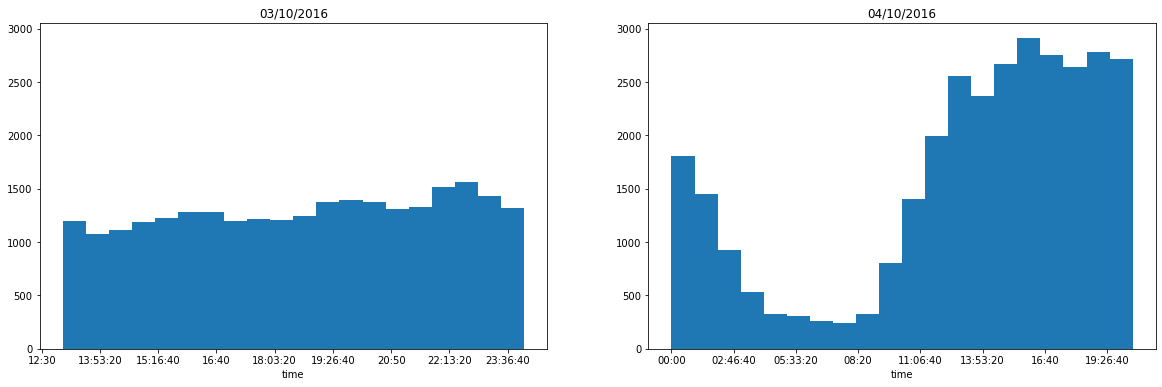

<Figure size 432x288 with 0 Axes>

In [48]:
fig=plt.figure(figsize = (20,6))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122, sharey = ax1)


ax1.hist(data_pickup[data_pickup.day == datetime.date(2016, 10, 3)].time, bins = 20)
ax1.set_title('03/10/2016')

ax2.hist(data_pickup[data_pickup.day == datetime.date(2016, 10, 4)].time, bins = 20)
ax2.set_title('04/10/2016')

plt.show()
plt.clf()

Because we only have data of 31h, we can't compare day by day evolution.

It would be interesting to know which days there are more trips.

## Answers:

- Should the company move towards road distance? What's the max price it would make sense to pay per query? (make all the assumptions you need, and make them explicit)
- How would you improve the experimental design? Would you collect any additional data?

As the p-value of the t-tests showed, it doesn't seem to be necessary to move towards road distance in all the cities. Pentos is the only city where the implementation would have a real change, and, as it's the city where most of the data was gathered, it's possible that it could be useful. It would be interesting to know the population of every city, or the size of the fleet, to know what this difference is due to.

Because we don't have the data for 5 days, we can't make a real valoration of the peaks of work and the price it would make sense to pay according to offer and demand. To make this assessment, we would need to evaluate the data for a month, to be able to pinpoint rush hours.

In case we could check on this data, it would be a way to create a variable tariff, with available cars per period and distance to the pickup point. This tariff would also have some variables, as mpl, that are not contemplated in the data available.